In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/Users/Jian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import re

In [3]:
import datetime

In [4]:
import os

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from plotting import *

In [7]:
import matplotlib.dates as mdt

In [8]:
from matplotlib.ticker import MaxNLocator


#### Example of parsing profile line

In [9]:
pline = 'I1229 14:40:01.965314 85775 MultiSolver.cpp:99] [1] PROFILING END[BComp] layer 15'

In [10]:
pd = parse_profile_log_line(pline)
pd

{'layer_id': 15,
 'pid': 85775,
 'prof_event': 'END',
 'prof_name': 'BComp',
 'remainder': '[1] PROFILING END[BComp] layer 15',
 'source_line': 'MultiSolver.cpp:99',
 'time': datetime.datetime(2017, 12, 29, 14, 40, 1, 965314),
 'worker_id': 1}

## Processing a bunch of profile lines

In [11]:
def time_profile_fb(log_file, line_limit=None, per_layer=False, worker_id=None, layer_id=None):    
    all_events = load_profiling_info(log_file, line_limit=line_limit)
    n_worker = int(log_file.split('W=')[1].split("_")[0] )

    print "total ", len(all_events)
    
    dt0 = all_events[0]['time']
    
    def base_lamb(entry):
        return True
    
    cnt = 0
    forward_time = 0
    backward_time = 0
    min_start_time = 1e15
    max_end_time = -1e15
    
    lamb_func = base_lamb
    if worker_id != None:
        lamb_func = lambda entry: entry['worker_id'] in worker_id
    if layer_id != None:
        lamb_func = lambda entry: lamb_func(entry) and entry['layer_id'] in layer_id
    
    all_events = filter(lamb_func, all_events)
    
    print "start sorting"
    
    all_events = sorted(all_events, key=lambda x: (x['time']-dt0).total_seconds() )
    
    print "start checking"
    for i, e in enumerate(all_events[1:] ):
        assert e['time'] >= all_events[i]['time']
    
    valid_cnt = 0
    for cnt, event in enumerate(all_events):
        if cnt < 1000 or event['prof_event'] != "BEGIN":
            continue
        try:
            end_event = next(e for e in all_events[cnt:] if e['prof_event']=='END' and \
                                e['prof_name']==event['prof_name'] and \
                                e['worker_id']==event['worker_id'] \
                                and e['time']>event['time'] \
                                and e['layer_id']==event['layer_id'])
            
        except:
            continue
            
        start_time = (event['time']-dt0).total_seconds()
        end_time = (end_event['time']-dt0).total_seconds()
        
        end_time = 1.0*(end_time-start_time) + start_time
        
        duration = end_time - start_time
#         if duration > 1 and (end_event['prof_name'] == "FComp" or end_event['prof_name'] == "BComp"):
#             print event, end_event
#             assert event['prof_event'] == "BEGIN" and end_event['prof_event'] == "END"
#             assert end_event['prof_name'] != "FComp" and end_event['prof_name'] != "BComp"
        assert duration >=0
    
        if event['worker_id'] == worker_id[0]:
            min_start_time = min(start_time, min_start_time)
            max_end_time = max(end_time, max_end_time)   
            
        if event['prof_name']=='FComp':
            color = 'blue'
            forward_time += duration
        elif event['prof_name']=='BComp':
            color = 'green'
            backward_time += duration

        if cnt % 5000 ==0:
            print "done ", cnt
        valid_cnt += 1
        
    print "total valid event ", valid_cnt
            
    total_time = max_end_time - min_start_time
    print "Forward time ", forward_time, float(forward_time) / float(total_time) / len(worker_id)
    print "Backward time ", backward_time, float(backward_time) / float(total_time) / len(worker_id)
    print "Total time ", total_time
    return float(forward_time) / float(total_time) / len(worker_id), float(backward_time) / float(total_time) / len(worker_id)

### 64 worker with server

In [14]:
worker_id_list = [3, ]

In [202]:
f_list = []
b_list = []

In [203]:
f, b = time_profile_fb('profile_log_cori_addition/W=64_G=1_LR=0.0003_mu=0.0.log', line_limit=600000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

total  600000
start sorting
start checking
done  5000
total valid event  4327
Forward time  17.857205 0.138933430792
Backward time  10.338744 0.0804379618198
Total time  128.530656


In [204]:
f, b = time_profile_fb('profile_log_cori_addition/W=64_G=4_LR=0.0003_mu=0.0.log', line_limit=400000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

total  400000
start sorting
start checking
done  5000
total valid event  3302
Forward time  14.980526 0.162121925303
Backward time  9.586783 0.103749876167
Total time  92.402838


In [205]:
f, b = time_profile_fb('profile_log_cori_addition/W=64_G=16_LR=0.0003_mu=0.0.log', line_limit=200000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

total  200000
start sorting
start checking
total valid event  463
Forward time  1.886633 0.0867122530001
Backward time  1.478117 0.0679362945882
Total time  21.757398


In [206]:
f, b = time_profile_fb('profile_log_cori_addition/W=64_G=32_LR=0.0003_mu=0.0.log', line_limit=250000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

total  250000
start sorting
start checking
total valid event  1201
Forward time  4.304458 0.113247491713
Backward time  2.700461 0.0710473733784
Total time  38.009301


In [207]:
f_list_server = list(f_list)
b_list_server = list(b_list)

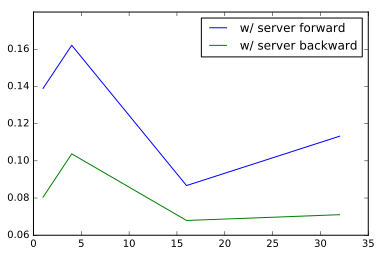

In [208]:
n_g = [1, 4, 16, 32]
plt.plot(n_g, f_list_server, label="w/ server forward")
plt.plot(n_g, b_list_server, label="w/ server backward")
plt.legend()

### no server 64 worker

In [209]:
f_list = []
b_list = []

In [1]:
worker_id_list = [3]
f, b = time_profile_fb('profile_log_cori_0102_wo_server/W=64_G=1_LR=0.0003_mu=0.0.log', line_limit=700000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

NameError: name 'time_profile_fb' is not defined

In [211]:
f, b = time_profile_fb('profile_log_cori_per_layer/W=64_G=4_LR=0.0003_mu=0.0.log', line_limit=400000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

total  400000
start sorting
start checking
done  5000
total valid event  3407
Forward time  18.931024 0.243725091063
Backward time  8.366685 0.107715835314
Total time  77.673677


In [13]:
f, b = time_profile_fb('profile_log_cori_per_layer/W=64_G=16_LR=0.0003_mu=0.0.log', line_limit=200000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

total  200000
start sorting
start checking
total valid event  1804
Forward time  6.944117 0.191111847095
Backward time  5.352558 0.14730990939
Total time  36.335356


NameError: name 'f_list' is not defined

In [213]:
f, b = time_profile_fb('profile_log_cori_per_layer/W=64_G=32_LR=0.0003_mu=0.0.log', line_limit=250000, worker_id=worker_id_list)
f_list.append(f)
b_list.append(b)

total  250000
start sorting
start checking
done  5000
done  10000
total valid event  4592
Forward time  31.122147 0.610002500211
Backward time  11.208565 0.219690906086
Total time  51.019704


In [214]:
f_list_no_server = list(f_list)
b_list_no_server = list(b_list)

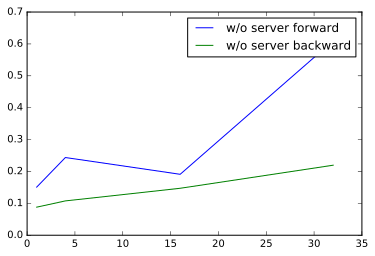

In [215]:
n_g = [1, 4, 16, 32]
plt.plot(n_g, f_list_no_server, label="w/o server forward")
plt.plot(n_g, b_list_no_server, label="w/o server backward")
plt.legend()

### w/ and w/o server using 64 servers (worker 8)

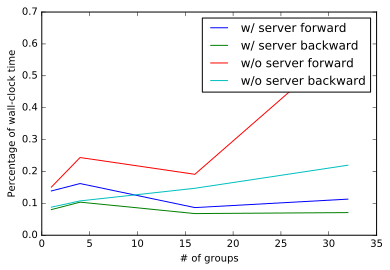

In [216]:
plt.plot(n_g, f_list_server, label="w/ server forward")
plt.plot(n_g, b_list_server, label="w/ server backward")
plt.plot(n_g, f_list_no_server, label="w/o server forward")
plt.plot(n_g, b_list_no_server, label="w/o server backward")
plt.xlabel("# of groups")
plt.ylabel("Percentage of wall-clock time")
plt.legend()

### worker 3

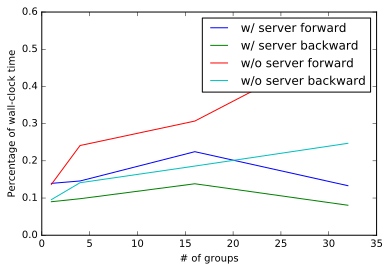

In [200]:
plt.plot(n_g, f_list_server, label="w/ server forward")
plt.plot(n_g, b_list_server, label="w/ server backward")
plt.plot(n_g, f_list_no_server, label="w/o server forward")
plt.plot(n_g, b_list_no_server, label="w/o server backward")
plt.xlabel("# of groups")
plt.ylabel("Percentage of wall-clock time")
plt.legend()